# EBL fluctuations

This example showcases how to plot EBL power spectra. 

Once again, we start with some imports:

In [1]:
%matplotlib inline

In [2]:
import ebl_utils
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Uncomment this if you like a black background
#pl.style.use('dark_background')

Let's arbitrarily pick two datasets to plot: one from CIBER (Zemcov et al. 2014) and one from Spitzer (Kashlinsky et al. 2012). **Note that these datasets are from very different experiments, operating at different wavelengths, and have assumed very different masking thresholds.** As a result, we are not expecting these sets of points to lie on top of each other!

In [4]:
z14 = ebl_utils.read('zemcov2014')
k12 = ebl_utils.read('kashlinsky2012')

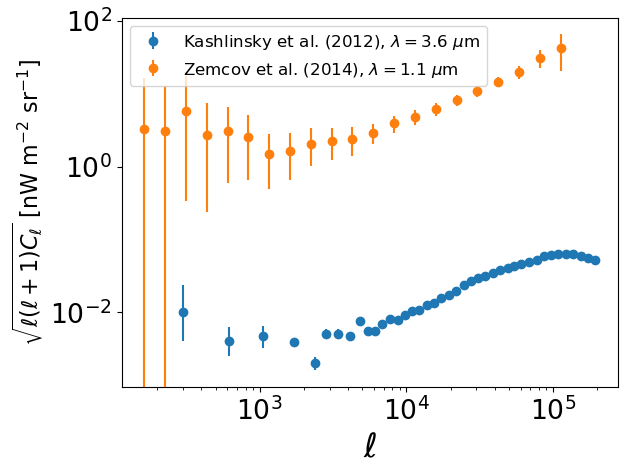

In [5]:
fig, ax = plt.subplots(1, 1)

colors = 'k', 'b'
for i, dataset in enumerate([k12, z14]):
    waves, scales, mean, err = dataset.get_ebl_anisotropies()
        
    k = 0  
        
    if np.array(err[k]).ndim == 1:
        ax.errorbar(scales, np.sqrt(mean[k]), yerr=np.sqrt(err[k]),
            fmt='o', label=dataset.name)
    else:
        ax.errorbar(scales, np.sqrt(mean[k]), yerr=np.sqrt(err[k])[:,-1::-1].T,
            fmt='o', label=dataset.name + r', $\lambda=%.1f \ \mu\rm{m}$' % waves[k])
        
ax.legend(fontsize=12)
ax.set_xlabel(r'$\ell$', fontsize=24)
ax.set_ylabel(ebl_utils.label_power)
ax.set_xscale('log')
ax.set_yscale('log')

People often plot the "anisotropy color," i.e., the power in a single multipole bin as a function of wavelength. Let's go ahead and give that a try. Once again, **this is a heterogeneous collection of data, interpret at your own risk.**

Text(0.95, 0.95, '$500 \\leq \\ell < 2000$')

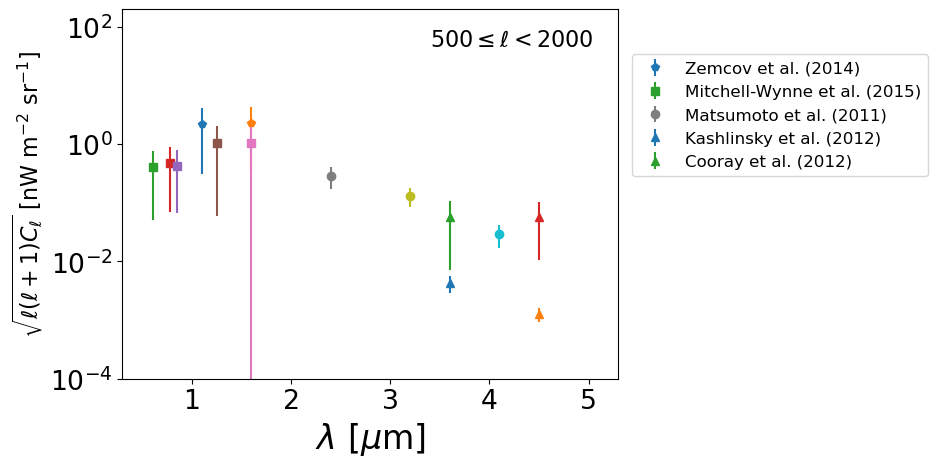

In [6]:
fig, ax = plt.subplots(1, 1)

# Focus on one big multipole bin
ell_bin = (500, 2e3)

# Loop over experiments, and datasets within each, then finally wavelength.
markers = 'p', 's', 'o', '^'
for k, experiment in enumerate(['ciber', 'hubble', 'akari', 'spitzer']):
    all_data = ebl_utils.read(experiment)
    
    # Possibly more than one set of measurements associated with a 
    # given observatory/experiment.
    for dset in all_data.all_datasets:
        
        # Some papers only focus on the mean EBL, skip those.
        if not hasattr(dset, 'get_ebl_anisotropies'):
            continue

        _waves, ell, _mean, _err = dset.get_ebl_anisotropies()
        
        for h, wave in enumerate(_waves):
    
            # Isolate data points that lie within the ell-bin 
            # we specified above.
            ok = np.logical_and(np.array(ell) >= ell_bin[0],
                                np.array(ell) <= ell_bin[1])
            
            # Plot the mean of all the data in the appropriate 
            # ell bin. Note that in practice one could reduce 
            # the error bars but let's ignore that for now.
            ax.errorbar(wave, np.sqrt(_mean[h])[ok==1].mean(),
                yerr=np.sqrt(_err[h])[ok==1].mean(),
                fmt=markers[k], 
                label=dset.name if h == 0 else None)

##
# Clean up a bit
ax.legend(fontsize=12, bbox_to_anchor=(1.01, 0.9))
ax.set_xlim(0.3, 5.3)
ax.set_yscale('log')
ax.set_ylim(1e-4, 200)
ax.set_xlabel(r'$\lambda \ [\mu\rm{m}]$', fontsize=24)
ax.set_ylabel(ebl_utils.label_power)
ax.annotate(r'$%i \leq \ell < %i$' % ell_bin,
        (0.95, 0.95), color='k',
        xycoords='axes fraction', ha='right', va='top')

## Comparing to foregrounds

In [7]:
import astropy.units as u
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

from zodipy import Zodipy

model = Zodipy("DIRBE")
nside = 256
wave = 3.6

zodi_map = model.get_binned_emission_pix(
    wave * u.micron,
    pixels=np.arange(hp.nside2npix(nside)),
    nside=nside,
    obs_time=Time("2024-02-28"),
    obs="earth",
)

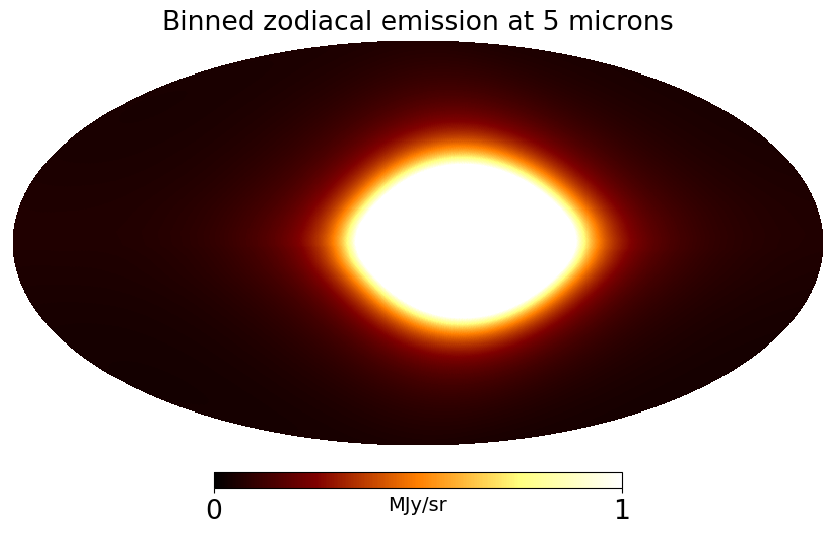

In [8]:
hp.mollview(
    zodi_map,
    title="Binned zodiacal emission at 5 microns",
    unit="MJy/sr",
    min=0,
    max=1,
    cmap="afmhot",
)

In [9]:
import healpy

freq = 2.99792e10 / (wave * 1e-4)

# in  MJy / sr
# 1 Jy = 1e-26  W / m^2 / Hz
MJy_to_nW = 1e6 * 1e-26 * 1e9

c_ell = healpy.sphtfunc.anafast(zodi_map * MJy_to_nW * freq)

In [10]:
ell = np.arange(c_ell.size)

(0.001, 1000.0)

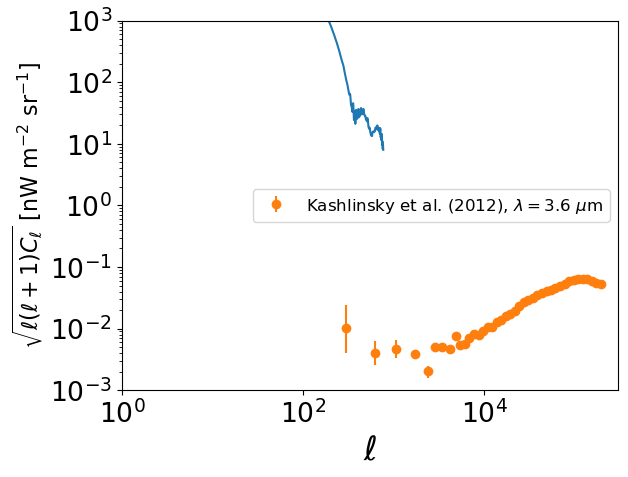

In [11]:
fig, ax = plt.subplots(1, 1)

ax.loglog(ell, np.sqrt(ell * (ell + 1) * c_ell / 2. / np.pi))

waves, scales, mean, err = k12.get_ebl_anisotropies()

k = 0 # Spitzer data is 3.6 and 4.5 microns
        
ax.errorbar(scales, np.sqrt(mean[k]), yerr=np.sqrt(err[k])[:,-1::-1].T,
    fmt='o', label=k12.name + r', $\lambda=%.1f \ \mu\rm{m}$' % waves[k])
        
ax.legend(fontsize=12)
ax.set_xlabel(r'$\ell$', fontsize=24)
ax.set_ylabel(ebl_utils.label_power)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 3e5)
ax.set_ylim(1e-3, 1e3)